In [1]:
# Import required packages
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import rioxarray
import seaborn as sns
import geopandas as gpd
from glob import glob
import gc
from matplotlib.dates import DateFormatter

In [2]:
# functions to load in mintpy data

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, cache=False)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpyInputs_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'reference_time',
                         'phony_dim_1':'secondary_time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'reference_time': ('reference_time', pd.to_datetime([span[0] for span in ds.date.values])),
                           'secondary_time': ('secondary_time', pd.to_datetime([span[1] for span in ds.date.values])),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop('date')
    ds = ds.rio.write_crs(crs)
    
    return ds

In [3]:
ts_fn = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_fusion/geo/geo_timeseries_ramp_demErr.h5'
crs = 4326
ts_ds = mintpyTS_to_xarray(ts_fn, crs)

In [4]:
imja_moraine_fn = './shapefiles/imja_moraine.shp'
imja_moraine_gdf = gpd.read_file(imja_moraine_fn)

In [5]:
def change_ref(xarray, lat, lon):
    rref_list = []
    reref = xarray.copy(deep=True)
    for i in range(xarray.sizes['time']):
        # get value from grid
        rref_list.append(float(xarray.isel(time=i).displacement.sel(x=lon, y=lat, method="nearest").values))
    reref['displacement'] = xarray['displacement'] - xr.DataArray(rref_list, dims='time')
    return reref  

In [6]:
rref_ts = change_ref(ts_ds, 27.90565, 86.91144)

In [7]:
imja_moraine = rref_ts.rio.clip(imja_moraine_gdf.geometry, crs=imja_moraine_gdf.crs, drop=True)

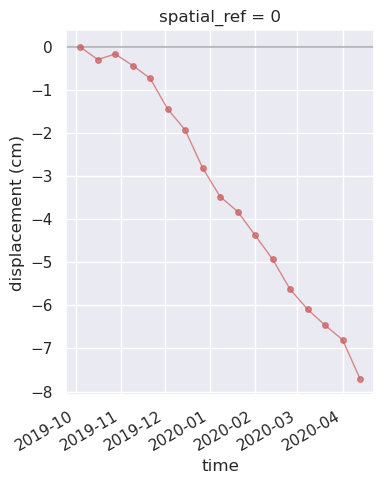

In [11]:
# correct displacements using variation in stable areas
sns.set_theme()
f, ax = plt.subplots(figsize=(4,5))
ax.axhline(y=0, c='gray', alpha=0.5)

(imja_moraine.displacement.median(dim=('x', 'y'))*100).plot(ax=ax, c='indianred', marker='o', markersize=4, linewidth=1, alpha=0.7)
ax.set_ylabel('displacement (cm)')
f.tight_layout()
plt.savefig('./figs/imja_ts.png', dpi=300)

In [44]:
LSG_0_fn = './shapefiles/LSG_0.shp'
LSG_0_gdf = gpd.read_file(LSG_0_fn)
LSG_1_fn = './shapefiles/LSG_1.shp'
LSG_1_gdf = gpd.read_file(LSG_1_fn)
LSG_2_fn = './shapefiles/LSG_2.shp'
LSG_2_gdf = gpd.read_file(LSG_2_fn)
LSG_3_fn = './shapefiles/LSG_3.shp'
LSG_3_gdf = gpd.read_file(LSG_3_fn)

In [27]:
def change_ref(xarray, lat, lon):
    rref_list = []
    reref = xarray.copy(deep=True)
    for i in range(xarray.sizes['time']):
        # get value from grid
        rref_list.append(float(xarray.isel(time=i).displacement.sel(x=lon, y=lat, method="nearest").values))
    reref['displacement'] = xarray['displacement'] - xr.DataArray(rref_list, dims='time')
    return reref  

In [28]:
rref_ts = change_ref(ts_ds, 27.90565, 86.91144)

In [45]:
LSG_0 = rref_ts.rio.clip(LSG_0_gdf.geometry, crs=LSG_0_gdf.crs, drop=True)
LSG_1 = rref_ts.rio.clip(LSG_1_gdf.geometry, crs=LSG_1_gdf.crs, drop=True)
LSG_2 = rref_ts.rio.clip(LSG_2_gdf.geometry, crs=LSG_2_gdf.crs, drop=True)
LSG_3 = rref_ts.rio.clip(LSG_3_gdf.geometry, crs=LSG_3_gdf.crs, drop=True)

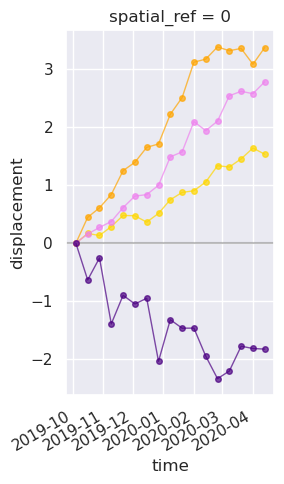

In [49]:
# correct displacements using variation in stable areas
sns.set_theme()
f, ax = plt.subplots(figsize=(3,5))
ax.axhline(y=0, c='gray', alpha=0.5)

LSG_0.displacement.median(dim=('x', 'y')).plot(ax=ax, c='orange', marker='o', markersize=4, linewidth=1, alpha=0.7)
LSG_1.displacement.median(dim=('x', 'y')).plot(ax=ax, c='gold', marker='o', markersize=4, linewidth=1, alpha=0.7)
LSG_2.displacement.median(dim=('x', 'y')).plot(ax=ax, c='violet', marker='o', markersize=4, linewidth=1, alpha=0.7)
LSG_3.displacement.median(dim=('x', 'y')).plot(ax=ax, c='indigo', marker='o', markersize=4, linewidth=1, alpha=0.7)
f.tight_layout()
plt.savefig('./figs/LSG_ts.png', dpi=300)